In [108]:

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from sklearn.metrics import roc_curve, auc
from torch.cuda.amp import autocast
from torch.utils.data import DataLoader
from tqdm import tqdm

from models.sfcn_original import SFCN
from utils.datasets import TorchDataset as TD

In [8]:
mode = 'test'
dataloader = DataLoader(TD(f'/data/Data/PD/{mode}'), batch_size=8, shuffle=False)

In [9]:
model = SFCN(output_dim=1, channel_number=[28, 58, 128, 256, 256, 64]).to('cuda')
checkpoint = torch.load('checkpoints/PD-SFCN/best_model.pt')
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [124]:
import torch

def print_shape_hook(self, input, output):
  print(f"Shape of output from {self.__class__.__name__}: {output.shape}")
  
# Assuming you have a model named 'model'
for name, module in model.named_modules():
  module.register_forward_hook(print_shape_hook)
  
# Assuming 'input_data' is your input tensor
output = model(next(iter(dataloader))[0].cuda())

Shape of output from Conv3d: torch.Size([8, 28, 160, 192, 160])
Shape of output from Conv3d: torch.Size([8, 28, 160, 192, 160])
Shape of output from Conv3d: torch.Size([8, 28, 160, 192, 160])
Shape of output from BatchNorm3d: torch.Size([8, 28, 160, 192, 160])
Shape of output from BatchNorm3d: torch.Size([8, 28, 160, 192, 160])
Shape of output from BatchNorm3d: torch.Size([8, 28, 160, 192, 160])
Shape of output from MaxPool3d: torch.Size([8, 28, 80, 96, 80])
Shape of output from MaxPool3d: torch.Size([8, 28, 80, 96, 80])
Shape of output from MaxPool3d: torch.Size([8, 28, 80, 96, 80])
Shape of output from ReLU: torch.Size([8, 28, 80, 96, 80])
Shape of output from ReLU: torch.Size([8, 28, 80, 96, 80])
Shape of output from ReLU: torch.Size([8, 28, 80, 96, 80])
Shape of output from Sequential: torch.Size([8, 28, 80, 96, 80])
Shape of output from Sequential: torch.Size([8, 28, 80, 96, 80])
Shape of output from Sequential: torch.Size([8, 28, 80, 96, 80])
Shape of output from Conv3d: torch.Si

In [121]:
for m in model.children():
    print(m)

Sequential(
  (conv_0): Sequential(
    (0): Conv3d(1, 28, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
  )
  (conv_1): Sequential(
    (0): Conv3d(28, 58, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
  )
  (conv_2): Sequential(
    (0): Conv3d(58, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
  )
  (conv_3): Sequential(
    (0): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 

In [27]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def accuracy(y_true, y_pred, threshold=0.5):
    y_pred = y_pred > threshold
    return np.mean(y_pred == y_true)

In [29]:
@torch.no_grad()
def test(model, dataloader, device='cuda'):
    model.eval()

    pd_true = []
    pd_pred = []
    study = []
    sex = []
    scanner = []
    for batch in tqdm(dataloader, desc='Test'):
        x = batch[0].to(device)
        pd_true += batch[1].tolist()
        sex += batch[2].tolist()
        study += batch[3].tolist()
        scanner += batch[4].tolist()

        # Forward pass with mixed precision
        with autocast():
            pd_pred += model(x).detach().cpu().tolist()

    return pd_true, pd_pred, sex, study, scanner

In [30]:
pd_true, pd_pred, sex, study, scanner = test(model, dataloader)

Test: 100%|██████████| 33/33 [00:05<00:00,  5.67it/s]


In [31]:
pd_pred = sigmoid(np.array(pd_pred).flatten())
pd_true = np.array(pd_true).flatten()
acc = accuracy(pd_true, pd_pred)

0.816793893129771

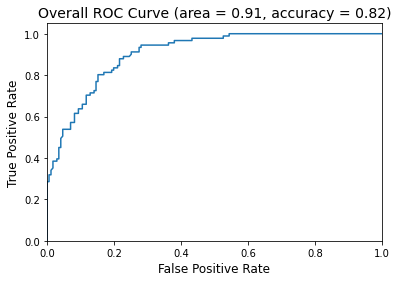

In [117]:
fpr, tpr, thresholds = roc_curve(pd_true, pd_pred)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'Overall ROC curve (area = {roc_auc})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title(f'Overall ROC Curve (area = {round(roc_auc,2)}, accuracy = {round(acc,2)})', fontsize=14)
plt.savefig(f'/data/Papers/MICCAI-biases/subgroup-analysis/overall.pdf', dpi=300)

In [32]:
import pandas as pd

df = pd.DataFrame({'pd_true': pd_true, 'pd_pred': pd_pred, 'sex': sex, 'study': study, 'scanner': scanner})
df

,pd_true,pd_pred,sex,study,scanner
0,1,0.061199,1,0,0
1,0,0.314261,1,0,0
2,1,0.943660,1,11,9
3,1,0.571886,0,4,4
4,0,0.152032,1,0,0
...,...,...,...,...,...
257,0,0.011072,0,6,5
258,1,0.103386,1,0,0
259,0,0.010209,1,6,5
260,1,0.885235,1,11,9


In [106]:


def compute_scanner_roc(df, y_true_col='pd_true', y_prob_col='pd_pred',
                        subgroup_col='scanner'):
    unique_scanners = df[subgroup_col].unique()

    scanner_roc_metrics = {}
    accuracy = {}
    for scanner in unique_scanners:
        # Filter dataframe for current scanner
        scanner_df = df[df[subgroup_col] == scanner]

        # Extract true labels and probabilities
        y_true = scanner_df[y_true_col]
        y_prob = scanner_df[y_prob_col]
        acc = np.mean(y_true == (1 * y_prob > 0.5))
        accuracy[scanner] = acc

        print(f'Accuracy for {subgroup_col} {scanner}: {acc} ')

        try:
            # Compute ROC curve
            fpr, tpr, thresholds = roc_curve(y_true, y_prob)
            roc_auc = auc(fpr, tpr)

            # Store metrics
            scanner_roc_metrics[scanner] = {
                'fpr': fpr,
                'tpr': tpr,
                'thresholds': thresholds,
                'auc': roc_auc,
                'total_samples': len(scanner_df)
            }

        except ValueError as e:
            print(f"Error computing ROC for {subgroup_col} {scanner}: {e}")

    return scanner_roc_metrics, accuracy


def plot_scanner_roc_curves(df, y_true_col='y_true', y_prob_col='y_pred',
                            subgroup_col='scanner', figsize=(12, 6)):
    # Compute ROC metrics for each scanner
    scanner_roc_metrics, accuracy = compute_scanner_roc(
        df, y_true_col, y_prob_col, subgroup_col
    )

    fig, axs = plt.subplots(1, 2, figsize=figsize)
    colors = sns.color_palette('husl', len(scanner_roc_metrics))

    # Plot ROC for each scanner
    for (scanner, metrics), color in zip(scanner_roc_metrics.items(), colors):
        axs[0].plot(metrics['fpr'], metrics['tpr'],
                    label=f'{scanner} (AUC = {metrics["auc"]:.3f}, n={metrics["total_samples"]})',
                    color=color)

    # Plot random classifier line
    axs[0].plot([0, 1], [0, 1], 'k--', label='Random Classifier')

    # Customize plot
    axs[0].set_xlim([0.0, 1.0])
    axs[0].set_ylim([0.0, 1.05])
    axs[0].set_xlabel('False Positive Rate', fontsize=12)
    axs[0].set_ylabel('True Positive Rate', fontsize=12)
    axs[0].set_title(f'ROC Curves by {subgroup_col}', fontsize=14)
    axs[0].legend(loc="lower right", fontsize=10)
    axs[0].grid(True, linestyle='--', alpha=0.7)

    axs[1].bar(accuracy.keys(), accuracy.values(), color=colors)
    axs[1].set_xlabel(f'{subgroup_col}', fontsize=12)
    axs[1].set_ylabel('Accuracy (threshold=0.5)', fontsize=12)
    axs[1].set_title(f'Accuracy by {subgroup_col}', fontsize=14)

    plt.tight_layout()
    plt.savefig(f'/data/Papers/MICCAI-biases/subgroup-analysis/{subgroup_col}.pdf', dpi=300)
    plt.show()

    return scanner_roc_metrics


# Comprehensive analysis function
def comprehensive_scanner_performance(df, y_true_col='pd_true', y_prob_col='pd_pred',
                                      subgroup_col='scanner', thresholds=None):
    if thresholds is None:
        thresholds = np.linspace(0, 1, 100)

    # Compute ROC curves
    roc_metrics = plot_scanner_roc_curves(df, y_true_col, y_prob_col, subgroup_col)

    return roc_metrics

Accuracy for sex 1: 0.8466257668711656 
Accuracy for sex 0: 0.7676767676767676 


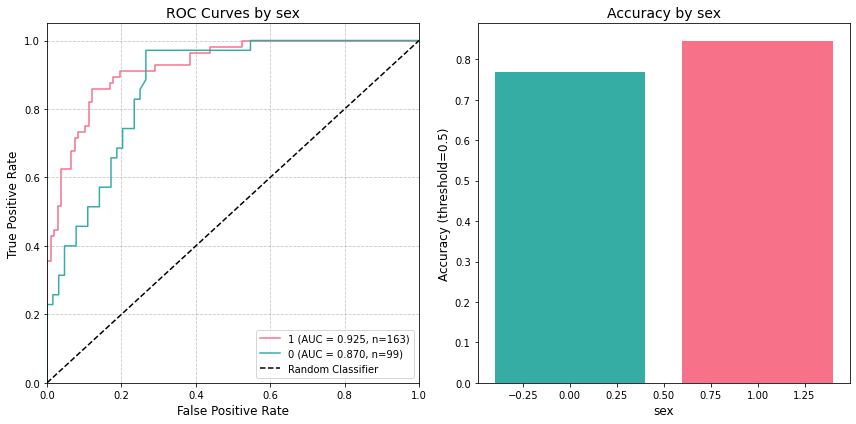


Scanner 1:
AUC: 0.925
Total Samples: 163

Scanner 0:
AUC: 0.870
Total Samples: 99


In [119]:
scanner_metrics = comprehensive_scanner_performance(df, subgroup_col='sex')

for scanner, metrics in scanner_metrics.items():
    print(f"\nScanner {scanner}:")
    print(f"AUC: {metrics['auc']:.3f}")
    print(f"Total Samples: {metrics['total_samples']}")